In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as oplgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import japanize_matplotlib

In [2]:
#このセルを実行すると保存したモデルを初期化します
Data = pd.read_csv(r"Dataset.csv",index_col=0,encoding="cp932")

In [3]:
models = {}

# 期間別時系列推移

In [4]:
# モード選択(Buy or Sell)
mode="Buy"
# 標準化
std_on=False

## データ前処理

- データはBuyとSell分析用に分けたあとそれぞれ上位1%を外れ値として除去
- 説明変数、被説明変数ともに標準化(平均：0，分散：1)
- 対象termを指定して期間を決定

In [6]:
if mode=="Buy":
    DataSetBuy = Data.drop(["ID", "ファンド名",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetBuy = DataSetBuy[DataSetBuy["設定額"]<DataSetBuy["設定額"].quantile(0.99)]
    
    #ここでtermを元データ(Data)から切り出しています
    # test_Data = DataSetBuy[DataSetBuy["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetBuy = DataSetBuy.loc[DataSetBuy[DataSetBuy["月"]=="2013/01"].index[0]\
                                :DataSetBuy[DataSetBuy["月"]=="2017/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetBuy.drop('設定額', axis=1)
    Y_train = DataSetBuy['設定額']
    
#     X_test = test_Data.drop('設定額', axis=1)
#     Y_test = test_Data['設定額']
    
    if std_on:
        #標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

    
elif mode=="Sell":
    DataSetSell = Data.drop(["ID", "ファンド名",\
                             "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetSell = DataSetSell[(DataSetSell["解約額"]<DataSetSell["解約額"].quantile(0.99))]
    
    #test_Data = DataSetSell[DataSetSell["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetSell = DataSetSell.loc[DataSetSell[DataSetSell["月"]=="2013/01"].index[0]\
                                  :DataSetSell[DataSetSell["月"]=="2017/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetSell.drop('解約額', axis=1)
    Y_train = DataSetSell['解約額']
    
#     X_test = test_Data.drop('解約額', axis=1)
#     Y_test = test_Data['解約額']
    
    if std_on:
        # 標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         Y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

else:
    print("Plese enter mode val 'Buy' or 'Sell'.")

## 学習（Optuna）

- 交差検証は10回行い、ハイパーパラメータを決定

In [7]:
# 訓練データ
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data = False)

kfold = KFold(n_splits=5,shuffle=True,random_state=0)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':0,
    "verbosity": -1
}

# Optunaでのパラメータ探索
tuner_cv = oplgb.LightGBMTunerCV(params, lgb_train, verbose_eval=-1,early_stopping_rounds=100,folds=kfold)

tuner_cv.run()

# 最適なパラメータの表示
best_params = tuner_cv.best_params
best_score = tuner_cv.best_score

test_size = 0.3  # 分割比率
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train, free_raw_data = False)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# 最適化パラメータで学習器構成
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test],early_stopping_rounds=100,verbose_eval=-1)
models[mode] = model

[I 2021-10-29 17:49:26,666] A new study created in memory with name: no-name-4c714717-40e2-483a-8918-6c30f96064de
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.030216:  14%|#4        | 1/7 [00:01<00:1

num_leaves, val_score: 0.030066:   5%|5         | 1/20 [00:01<00:21,  1.13s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.030066:  10%|#         | 2/20 [00:05<00:36,  2.03s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'e

num_leaves, val_score: 0.030066:  45%|####5     | 9/20 [00:30<00:35,  3.19s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.030066:  50%|#####     | 10/20 [00:34<00:34,  3.42s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: '

num_leaves, val_score: 0.030066:  85%|########5 | 17/20 [00:53<00:07,  2.44s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.030066:  90%|######### | 18/20 [00:54<00:04,  2.09s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 

bagging, val_score: 0.030066:  50%|#####     | 5/10 [00:07<00:07,  1.50s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.030066:  60%|######    | 6/10 [00:08<00:05,  1.44s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_s

regularization_factors, val_score: 0.030066:  20%|##        | 4/20 [00:05<00:24,  1.52s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.030066:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.030028:  90%|######### | 18/20 [00:28<00:03,  1.56s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.030028:  95%|#########5| 19/20 [00:29<00:01,  1.51s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engi

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's rmse: 0.0295151



/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


# 結果（Buy）

In [8]:
Buy_X = X_train
Buy_Y = Y_train
Buy_set = pd.concat([Buy_Y,Buy_X],axis=1,sort=False).reset_index(drop=True)
#Buy_set.to_csv()

In [9]:
#Buy all
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 3.1708170921053124e-05,
 'lambda_l2': 1.7286007343285115e-06,
 'num_leaves': 31,
 'feature_fraction': 0.6479999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [10]:
pred_list_Buy = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Buy.append(nrmse_score)

Text(0, 0.5, 'pred')

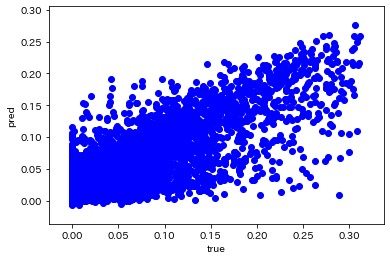

In [11]:
plt.scatter(Y_train, Y_pred,c='b')
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# 結果（Sell）

In [7]:
Sell_X = X_train
Sell_Y = Y_train
Sell_set = pd.concat([Sell_Y,Sell_X],axis=1,sort=False).reset_index(drop=True)
#Sell_set.to_csv()

In [8]:
# Sell
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 1.8847466786271963e-05,
 'lambda_l2': 1.1787256281854725e-08,
 'num_leaves': 62,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [11]:
pred_list_Sell = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Sell.append(nrmse_score)

Text(0, 0.5, 'pred')

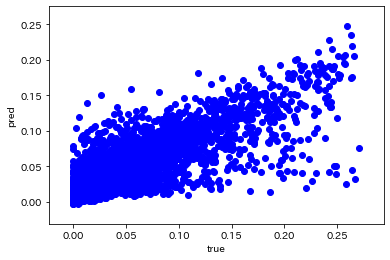

In [13]:
plt.scatter(Y_train, Y_pred,c='b');
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# SHAPley(Buy)

In [12]:
import shap
shap.initjs()

In [13]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(Buy_X,10000)
shap_v = explainer.shap_values(X=Buy_X)
Buy_shap_v = shap_v

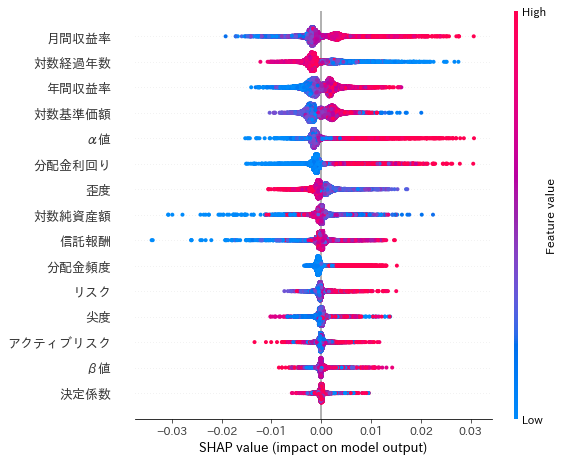

In [14]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

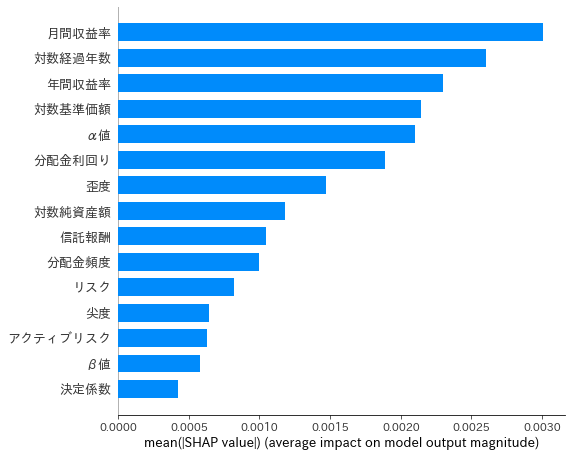

In [15]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,plot_type="bar",max_display=20)
# plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [16]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

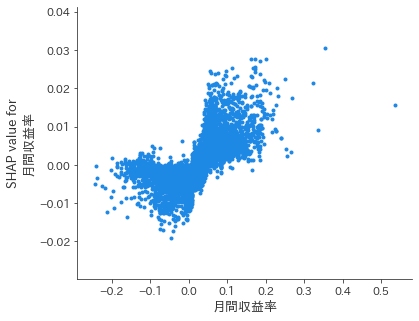

In [17]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '月間収益率', False)# 基準価額の値は対数変換されています

<Figure size 1080x1080 with 0 Axes>

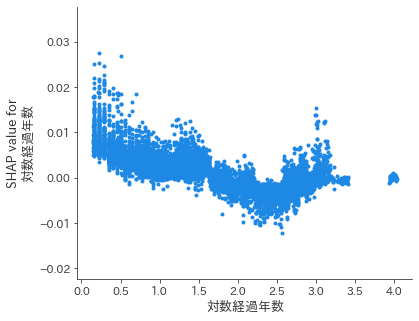

In [18]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

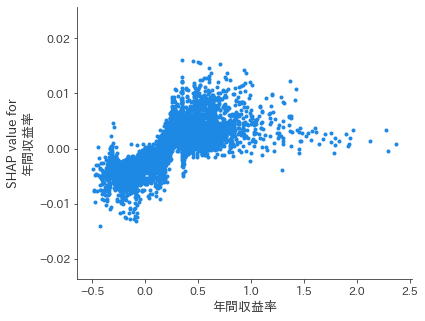

In [19]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '年間収益率', False)

<Figure size 1080x1080 with 0 Axes>

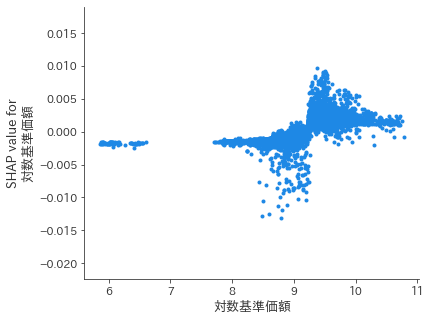

In [21]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

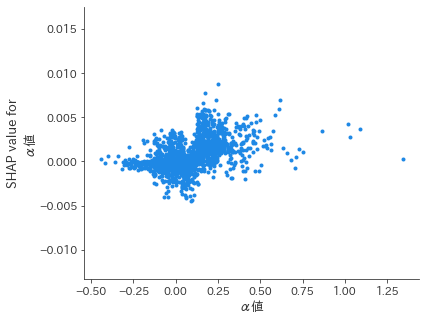

In [22]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'α値', False)

<Figure size 1080x1080 with 0 Axes>

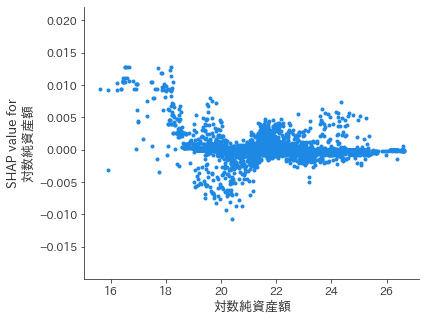

In [23]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数純資産額', False)

<Figure size 1080x1080 with 0 Axes>

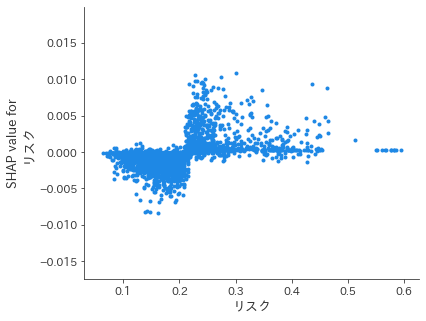

In [24]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'リスク',False)

<Figure size 1080x1080 with 0 Axes>

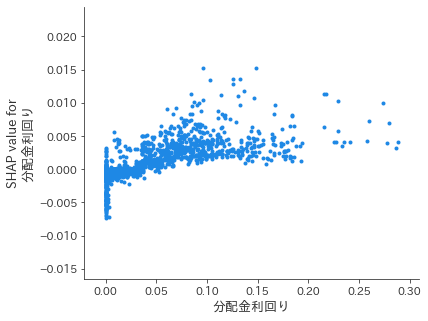

In [25]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '分配金利回り', False)

In [20]:
DF_Buy_shap = pd.DataFrame(Buy_shap_v,columns=Buy_X.columns[:])
DF_Buy_shap.to_csv("Buy_sv_term4.csv")

DF_Buy = pd.DataFrame(Buy_X,columns=Buy_X.columns[:])
DF_Buy.to_csv("Buy_term4.csv")

DF_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.019937,6.405179e-04,-0.001488,0.003598,-0.001259,-6.393391e-05,0.001783,0.000456,-0.001964,0.000154,-0.001980,0.000020,0.000178,-0.000008,0.000350,-0.000959
1,-0.016864,9.438367e-05,-0.000871,0.003637,-0.002521,2.161631e-04,0.000630,0.000524,-0.000918,-0.003235,-0.001098,-0.000202,0.000240,0.000051,-0.000308,-0.001290
2,-0.017694,-3.874256e-04,-0.002458,0.003466,0.000189,-3.783084e-04,0.001499,0.000223,-0.001762,-0.001148,-0.001724,-0.000149,0.000245,0.000343,-0.000039,-0.000733
3,-0.018729,-1.499932e-04,-0.000968,0.003584,-0.001182,2.948484e-06,0.001338,0.000300,-0.001174,-0.002904,-0.001590,-0.000041,0.000012,-0.000005,-0.000606,-0.001056
4,-0.016567,1.169504e-04,-0.002459,0.004581,0.001778,-1.795155e-04,0.003694,0.000386,-0.000553,-0.002357,-0.001734,-0.000071,0.000074,0.000112,-0.000270,-0.000763
5,-0.019521,2.325329e-04,-0.001482,0.004861,0.001896,-5.775137e-07,0.002534,0.000490,-0.001221,-0.003108,-0.001324,-0.000103,0.000077,-0.000270,-0.000247,-0.001001
6,-0.016999,4.338465e-05,-0.000515,-0.000947,-0.001490,-2.769509e-04,0.000770,0.000279,-0.001932,-0.001168,-0.001200,0.000651,-0.000247,0.002024,-0.000198,-0.000899
7,-0.017126,8.079406e-04,-0.002546,0.002082,-0.001260,-9.193085e-04,0.000573,0.000072,-0.001926,0.003617,-0.000968,-0.000959,0.000102,-0.000215,-0.001115,-0.000553
8,-0.017079,5.323882e-04,-0.000954,0.003765,-0.001211,-1.721058e-05,0.001281,0.000191,-0.001444,-0.002947,-0.001827,-0.000061,-0.000006,0.000041,-0.000564,-0.001049
9,-0.017407,7.962451e-04,-0.002574,0.004302,-0.000440,4.314118e-05,0.001617,0.000170,-0.001291,-0.003378,-0.001752,-0.000061,0.000183,0.000125,0.000682,-0.000588


#  

## 特定ファンド

In [21]:
target_data_term4 = pd.read_csv(r"/Users/chuudoutakuma/投信資金フロー/中道/for_nakamichi/プログラム/allterm/target_data_term4.csv",index_col=0)

In [22]:
target_Buy_X = target_data_term4.drop(["ID", "ファンド名","設定額","月",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Buy_Y = target_data_term4['設定額']
target_Buy_set = pd.concat([target_Buy_Y,target_Buy_X],axis=1,sort=False).reset_index(drop=True)

In [23]:
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(target_Buy_X,10000)
shap_v = explainer.shap_values(X=target_Buy_X)
Buy_shap_v = shap_v

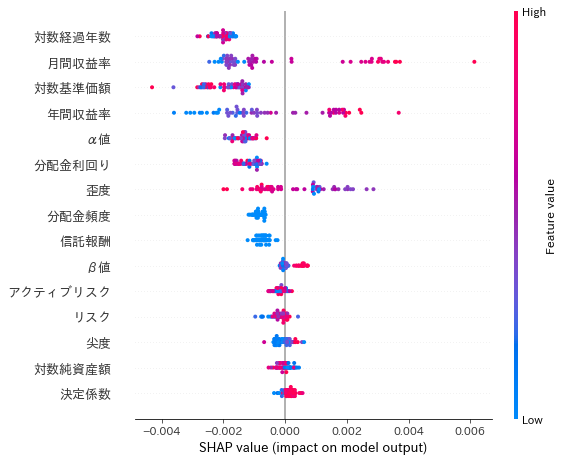

In [24]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=target_Buy_X.iloc[:,1:],feature_names=target_Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [25]:
DF_target_Buy_shap = pd.DataFrame(Buy_shap_v,columns=target_Buy_X.columns[:])
DF_target_Buy_shap.to_csv("target_Buy_sv_term4.csv")

DF_target_Buy = pd.DataFrame(target_Buy_X,columns=target_Buy_X.columns[:])
DF_target_Buy.to_csv("target_Buy_term4.csv")

DF_target_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.016828,-0.000025,-0.001174,0.003719,-0.000568,-2.748209e-04,0.001589,2.314426e-04,-0.000977,-0.002314,-0.001713,-0.000069,0.000024,0.000221,-0.000685,-0.001184
1,-0.019159,-0.000188,-0.001748,0.003560,0.001752,-1.045519e-04,0.002025,1.248978e-04,-0.001094,-0.002389,-0.001533,0.000110,-0.000021,-0.000188,-0.000668,-0.000990
2,-0.017239,-0.000178,-0.001273,-0.000430,-0.001087,-2.680844e-05,0.001541,7.385939e-05,-0.001430,-0.001585,-0.001367,0.000034,0.000257,-0.000222,-0.000714,-0.001139
3,-0.017000,-0.000140,-0.002098,0.003335,0.001213,-1.527260e-04,0.002641,2.617746e-04,-0.001608,-0.001617,-0.001704,0.000084,0.000046,-0.000045,-0.000517,-0.001022
4,-0.015931,0.000092,-0.003618,0.006132,0.003681,8.722617e-05,0.002862,5.475316e-04,-0.001273,-0.002233,-0.001688,-0.000084,-0.000085,-0.000462,-0.000246,-0.000978
5,-0.009955,0.000039,-0.002638,-0.001986,0.001966,-7.579154e-05,-0.001122,-3.612328e-04,-0.001530,-0.001789,-0.001167,-0.000011,0.000341,-0.000417,-0.000520,-0.000703
6,-0.014382,0.000034,-0.002636,-0.001868,0.001953,5.409768e-05,-0.000905,-1.896901e-04,-0.001423,-0.001716,-0.001016,-0.000055,0.000264,-0.000545,-0.000617,-0.000688
7,-0.014104,0.000023,-0.002732,-0.002024,0.001572,-1.662368e-04,-0.000866,-2.000877e-04,-0.001221,-0.001688,-0.001294,0.000506,0.000462,-0.000477,-0.000769,-0.000674
8,-0.014373,-0.000270,-0.002502,-0.002458,0.001431,-2.531145e-04,-0.001387,-3.372551e-04,-0.001645,-0.001644,-0.001309,0.000292,0.000315,-0.000527,-0.000582,-0.000671
9,-0.016779,-0.000170,-0.002717,0.003010,0.002420,-1.911949e-04,-0.000758,-3.809097e-04,-0.001642,-0.002385,-0.001643,0.000370,-0.000010,-0.000291,-0.000562,-0.000673


# SHAPley(Sell)

In [15]:
import shap
#plt.rcParams['font.family'] = "Yu Gothic"
shap.initjs()

In [18]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(Sell_X,10000)
shap_v = explainer.shap_values(X=Sell_X)
Sell_shap_v = shap_v

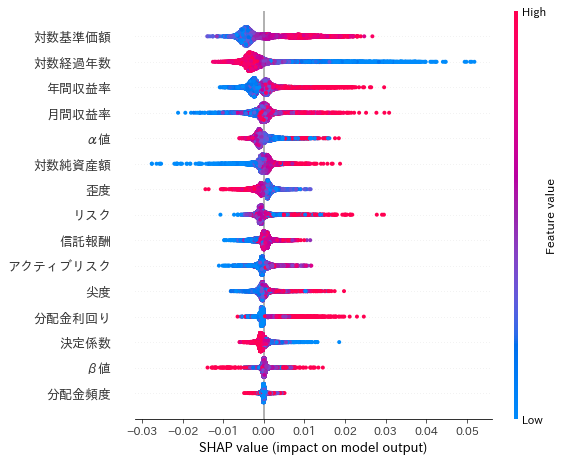

In [21]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

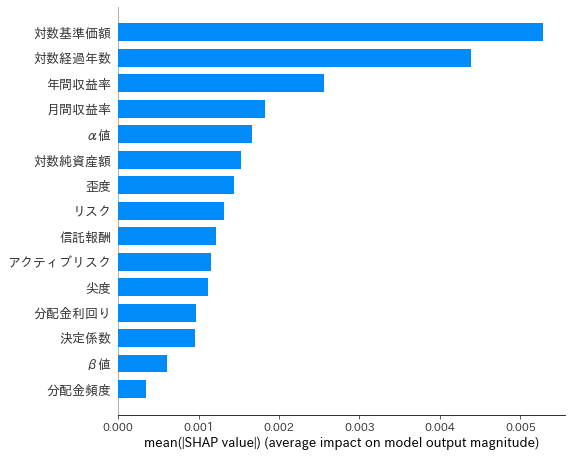

In [23]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20,plot_type="bar")
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [29]:
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

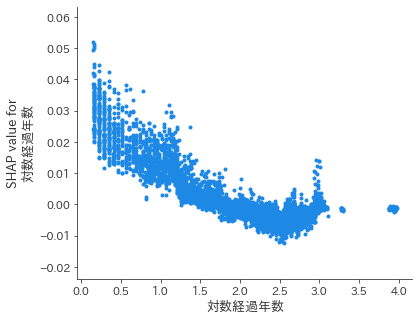

In [30]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

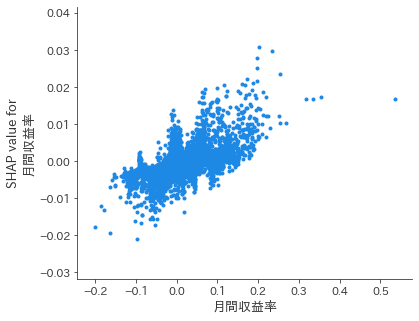

In [31]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

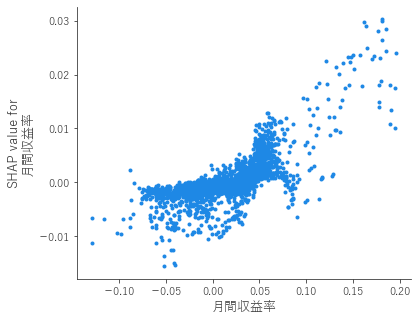

In [22]:
shap_plot(Sell_shap_v, X_test, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

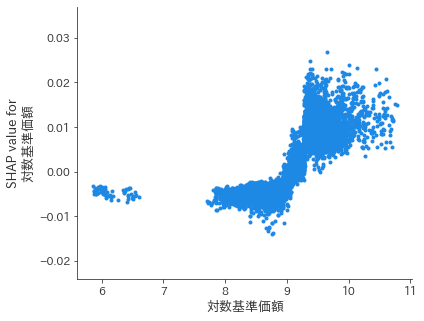

In [32]:
shap_plot(Sell_shap_v,Sell_X, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

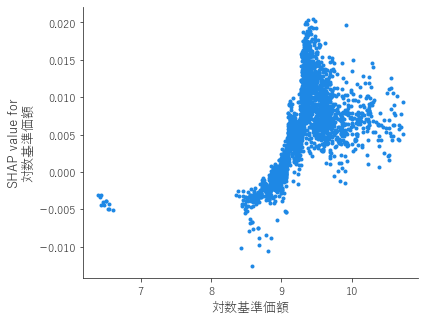

In [23]:
shap_plot(Sell_shap_v, X_test, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

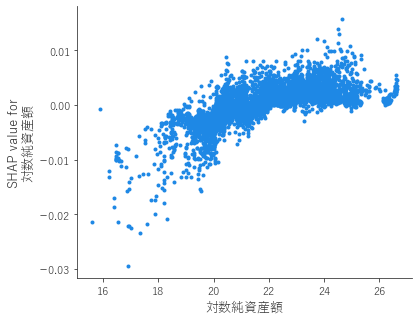

In [50]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数純資産額', True)

<Figure size 1080x1080 with 0 Axes>

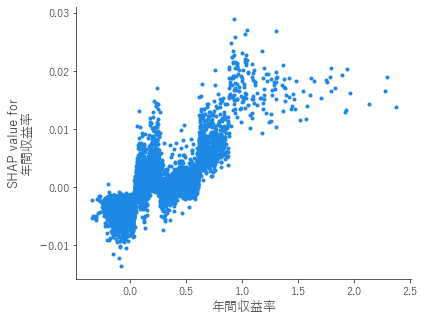

In [47]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

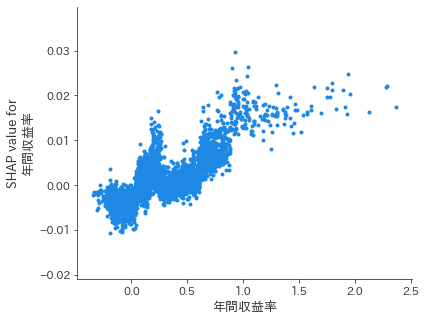

In [34]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

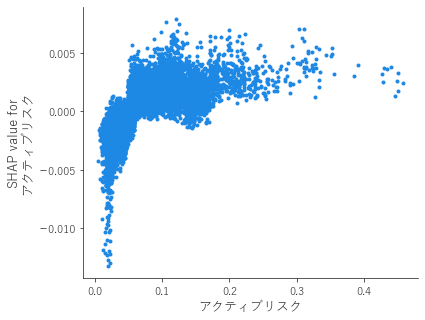

In [64]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'アクティブリスク', True)

<Figure size 1080x1080 with 0 Axes>

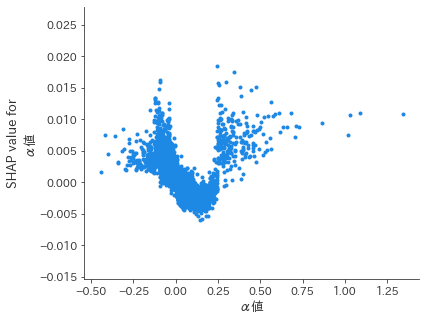

In [33]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

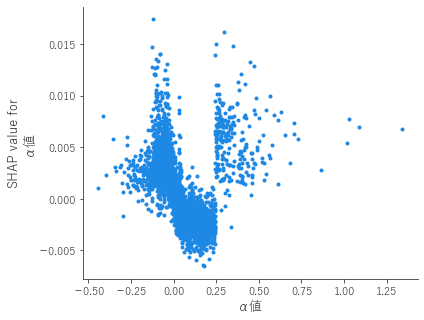

In [48]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

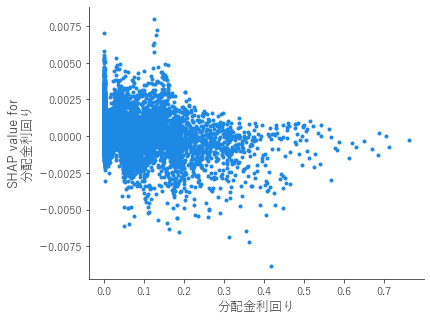

In [72]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '分配金利回り', False)

In [49]:
DF_Sell_shap = pd.DataFrame(Sell_shap_v,columns=Sell_X.columns[:])
DF_Sell_shap.to_csv()
DF_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.019862,-0.000201,-0.005300,0.002988,0.001431,-0.000462,-0.002683,-0.004216,-0.000591,-0.005013,-0.002524,0.000580,-0.000274,0.001818,0.002326,0.000230
1,0.022761,0.002025,-0.005464,-0.001104,0.000008,0.000147,0.000283,0.005095,-0.000676,0.014170,-0.000733,-0.000300,-0.000792,-0.000671,0.003361,0.000321
2,-0.005590,0.000781,-0.005542,-0.000166,0.000688,-0.000386,-0.000521,0.001728,-0.000501,-0.004101,-0.001097,0.000029,-0.000076,0.000204,0.000351,0.000155
3,-0.004679,-0.000085,-0.005819,-0.000309,0.000979,-0.000585,0.001262,-0.001125,-0.000398,-0.003099,-0.001718,0.000023,0.000393,0.001060,-0.000859,0.000430
4,-0.003119,0.002625,-0.004487,-0.000096,0.001360,-0.000722,-0.000177,-0.001432,-0.000406,-0.001344,-0.000871,0.000254,-0.000495,-0.001249,0.000404,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,0.020089,-0.000062,0.007273,0.002546,-0.004850,-0.001187,-0.001986,0.001336,-0.000159,-0.002462,0.002286,-0.001279,0.003151,-0.001548,-0.002860,-0.000228
11401,0.020520,0.000427,-0.006735,-0.001256,0.001205,-0.002090,-0.001415,0.005641,0.000047,-0.002750,0.001160,0.000853,0.005721,0.000720,0.000958,-0.000018
11402,0.044422,0.006032,0.022504,0.003597,0.007003,0.008174,0.005411,0.005479,0.001060,0.004584,0.012105,0.005634,0.011959,0.009664,0.003488,-0.000132
11403,0.035301,0.005905,0.016795,0.004753,-0.000307,-0.002053,0.000631,0.001531,0.000806,0.003226,0.006854,0.000907,-0.001123,-0.010146,0.000665,0.000505
